#Proyect objective
The objective of this project is to evaluate whether self-reported health, lifestyle, and demographic indicators collected through a large population survey can be used to identify individuals at increased risk of diabetes.

Rather than aiming for clinical diagnosis, the problem is framed as a binary risk screening task, where the priority is to detect as many at-risk individuals as possible while maintaining reasonable model interpretability and robustness.

#Import required libraries



In [ ]:
!pip install catboost

In [ ]:
from itertools import product
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import kagglehub
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)


# Obtain dataset

In [ ]:
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-health-indicators-dataset


In [ ]:
original_df = pd.read_csv(path + "/diabetes_012_health_indicators_BRFSS2015.csv")
df = original_df.copy()
df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


#Data cleaning and wrangling

<font color="#00868B" size = "3"><b>Handling missing values</b></font>

In [ ]:
cols_with_nulls = df.columns[df.isnull().any()]
df[df.isnull().any(axis=1)][cols_with_nulls] # Shows columns containing missing values

""


No missing values in this dataset to be managed

In [ ]:
# Explore the names of the different columns
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

<font color="#00868B" size = "3"><b>Improving column naming for more clarity, target variable transformation and data type managing</b></font>

In [ ]:
df = df.rename(columns={
    'Diabetes_012': 'diabetes_status',
    'HighBP': 'high_blood_pressure',
    'HighChol': 'high_cholesterol',
    'CholCheck': 'cholesterol_checked',
    'BMI': 'body_mass_index',
    'Smoker': 'frequent_smoker',
    'Stroke': 'had_stroke',
    'HeartDiseaseorAttack': 'heart_disease_or_attack',
    'PhysActivity': 'physically_active',
    'Fruits': 'daily_fruit_intake',
    'Veggies': 'daily_vegetable_intake',
    'HvyAlcoholConsump': 'heavy_alcohol_consumption',
    'AnyHealthcare': 'has_healthcare_coverage',
    'NoDocbcCost': 'cost_barrier_to_doctor',
    'GenHlth': 'general_health_rating',
    'MentHlth': 'days_with_poor_mental_health',
    'PhysHlth': 'days_with_poor_physical_health',
    'DiffWalk': 'difficulty_walking',
    'Sex': 'sex',
    'Age': 'age_group',
    'Education': 'education_level',
    'Income': 'income_bracket'
})

The target variable was converted into a binary outcome by merging classes 1 (prediabetes) and 2 (diabetes)

In [ ]:
df["diabetes_status"] = df["diabetes_status"].replace({2: 1})

Inspect the data type of each column and convert columns to more appropriate and manageable data types

In [ ]:
df.dtypes # data type

,0
diabetes_status,float64
high_blood_pressure,float64
high_cholesterol,float64
cholesterol_checked,float64
body_mass_index,float64
frequent_smoker,float64
had_stroke,float64
heart_disease_or_attack,float64
physically_active,float64
daily_fruit_intake,float64


In [ ]:
# Change data type to adequate ones
for col in df.columns:
    if col in ["body_mass_index", "days_with_poor_mental_health", "days_with_poor_physical_health"]:
        assert (df[col] % 1 == 0).all(), f"The column {col} contains non-integer values"
        df[col] = df[col].astype(int)

    else: df[col] = df[col].astype("category")

In [ ]:
df.dtypes

,0
diabetes_status,category
high_blood_pressure,category
high_cholesterol,category
cholesterol_checked,category
body_mass_index,int64
frequent_smoker,category
had_stroke,category
heart_disease_or_attack,category
physically_active,category
daily_fruit_intake,category


<font color="#00868B" size = "3"><b>Handling duplicates</b></font>

In [ ]:
df[df.duplicated()] # Shows duplicated rows

,diabetes_status,high_blood_pressure,high_cholesterol,cholesterol_checked,body_mass_index,frequent_smoker,had_stroke,heart_disease_or_attack,physically_active,daily_fruit_intake,...,has_healthcare_coverage,cost_barrier_to_doctor,general_health_rating,days_with_poor_mental_health,days_with_poor_physical_health,difficulty_walking,sex,age_group,education_level,income_bracket
1242,1.0,1.0,1.0,1.0,27,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,0,30,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0,0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0,0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0,0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0,0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,1.0,1.0,1.0,1.0,33,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0,0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0,0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0,0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0,0,0.0,0.0,5.0,6.0,8.0


In [ ]:
n_total = len(df)
n_unique = df.drop_duplicates().shape[0]
dup_pct = 100 - (n_unique * 100 / n_total)

print(f"number of total rows: {n_total}")
print(f"number of unique rows: {n_unique}")
print(f"percentage of duplicated rows: {dup_pct:.2f}%")

number of total rows: 253680
number of unique rows: 229712
percentage of duplicated rows: 9.45%


In [ ]:
# Distribution of diabetes_status within duplicated rows
df[df.duplicated()]["diabetes_status"].value_counts(normalize=True)

,proportion
diabetes_status,
0.0,0.986649
1.0,0.013351


In [ ]:
# Distribution of diabetes_status within total rows
df["diabetes_status"].value_counts(normalize=True)

,proportion
diabetes_status,
0.0,0.842412
1.0,0.157588


An analysis of duplicated rows revealed that approximately 9.4% of the dataset contains identical feature combinations. Given the absence of unique identifiers and the highly discretized nature of the variables, these duplicated records cannot be confidently interpreted as data entry errors. Instead, they likely reflect common population profiles captured multiple times in a large-scale survey.

Class distribution analysis showed a strong imbalance toward non-diabetic individuals, which is even more pronounced among duplicated records. To avoid distorting the underlying population structure, duplicated observations were retained. Their potential influence on model estimates is addressed during the modeling stage through class-weighted loss functions, regularization, and cross-validated evaluation, rather than by removing observations at this stage.

<font color="#00868B" size = "3"><b>Imrpving value encoding for exploratory data analysis</b></font>

Encoded column values are replaced with descriptive labels for improved readability:

In [ ]:
df_eda = df.copy()

df_eda["diabetes_status"] = df_eda["diabetes_status"].replace({0: "healthy", 1: "diabetic", 2: "diabetic"})
df_eda["high_blood_pressure"] = df_eda["high_blood_pressure"].replace({0: "no", 1: "yes"})
df_eda["high_cholesterol"] = df_eda["high_cholesterol"].replace({0: "no", 1: "yes"})
df_eda["cholesterol_checked"] = df_eda["cholesterol_checked"].replace({0: "no", 1: "yes"})
df_eda["frequent_smoker"] = df_eda["frequent_smoker"].replace({0: "no", 1: "yes"})
df_eda["had_stroke"] = df_eda["had_stroke"].replace({0: "no", 1: "yes"})
df_eda["heart_disease_or_attack"] = df_eda["heart_disease_or_attack"].replace({0: "no", 1: "yes"})
df_eda["physically_active"] = df_eda["physically_active"].replace({0: "no", 1: "yes"})
df_eda["daily_fruit_intake"] = df_eda["daily_fruit_intake"].replace({0: "no", 1: "yes"})
df_eda["daily_vegetable_intake"] = df_eda["daily_vegetable_intake"].replace({0: "no", 1: "yes"})
df_eda["heavy_alcohol_consumption"] = df_eda["heavy_alcohol_consumption"].replace({0: "no", 1: "yes"})
df_eda["has_healthcare_coverage"] = df_eda["has_healthcare_coverage"].replace({0: "no", 1: "yes"})
df_eda["cost_barrier_to_doctor"] = df_eda["cost_barrier_to_doctor"].replace({0: "no", 1: "yes"})
df_eda["general_health_rating"] = df_eda["general_health_rating"].replace({1: "excellent", 2: "very good", 3: "good", 4: "fair", 5: "poor"})
df_eda["difficulty_walking"] = df_eda["difficulty_walking"].replace({0: "no", 1: "yes"})
df_eda["sex"] = df_eda["sex"].replace({0: "female", 1: "male"})
df_eda["age_group"] = df_eda["age_group"].replace({1: "18-24", 2: "25-29", 3: "30-34", 4: "35-39", 5: "40-44", 6: "45-49",
                                           7: "50-54", 8: "55-59", 9: "60-64", 10: "65-69", 11: "70-74", 12: "75-79",
                                           13: "80+"})
df_eda["education_level"] = df_eda["education_level"].replace({1: "no formal education", 2: "elementary school", 3: "incomplete high school",
                                                        4: "high school graduated", 5: "incomplete college", 6: "college graduate"})
df_eda["income_bracket"] = df_eda["income_bracket"].replace({1: "lower than 10k", 2: "10-15k", 3: "15-20k", 4: "20-25k", 5: "25-35k", 6: "35-50k",
                                                     7: "50-75k", 8: "75k or more"})

/tmp/ipython-input-561906100.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_eda["diabetes_status"] = df_eda["diabetes_status"].replace({0: "healthy", 1: "diabetic", 2: "diabetic"})
/tmp/ipython-input-561906100.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_eda["high_blood_pressure"] = df_eda["high_blood_pressure"].replace({0: "no", 1: "yes"})
/tmp/ipython-input-561906100.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that prese

Inspect unique values per column to ensure all categories were properly recoded:

In [ ]:
for col in df_eda.columns:
    print(col, df_eda[col].unique())

diabetes_status ['healthy', 'diabetic']
Categories (2, object): ['healthy', 'diabetic']
high_blood_pressure ['yes', 'no']
Categories (2, object): ['no', 'yes']
high_cholesterol ['yes', 'no']
Categories (2, object): ['no', 'yes']
cholesterol_checked ['yes', 'no']
Categories (2, object): ['no', 'yes']
body_mass_index [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
frequent_smoker ['yes', 'no']
Categories (2, object): ['no', 'yes']
had_stroke ['no', 'yes']
Categories (2, object): ['no', 'yes']
heart_disease_or_attack ['no', 'yes']
Categories (2, object): ['no', 'yes']
physically_active ['no', 'yes']
Categories (2, object): ['no', 'yes']
daily_fruit_intake ['no', 'yes']
Categories (2, object): ['no', 'yes']
daily_vegetable_intake ['yes', 'no']
Categories (2, object): ['no', 'yes']
hea

#Exporting cleaned data

In [ ]:
# Export the cleaned and feature-engineered DataFrame to a CSV file
df_eda.to_csv("Cleaned_diabetes_health_indicators.csv", index=False)

# Exploratory Data Analysis

<font color="#00868B" size = "3"><b>Visualizing data from numerical columns</b></font>

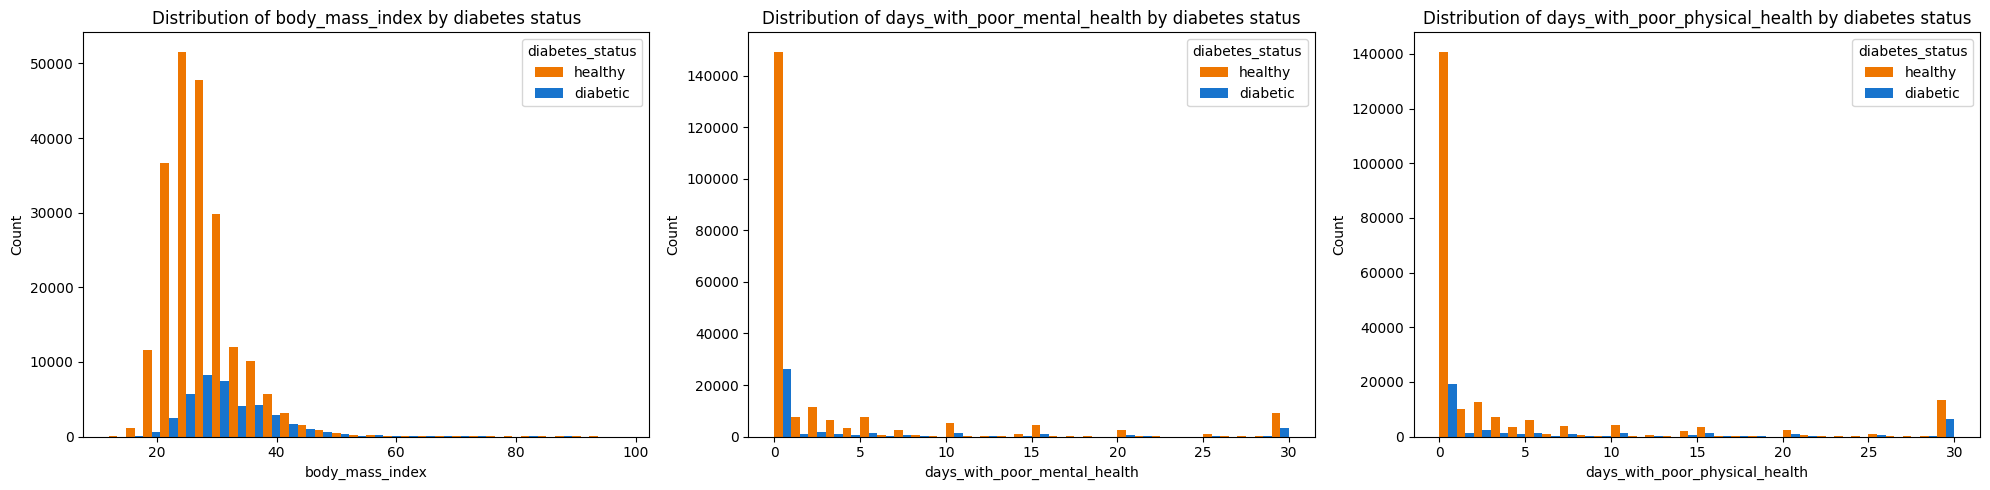

In [ ]:
# Select only columns with integer type (non-binary)
numerical_columns = [
    "body_mass_index",
    "days_with_poor_mental_health",
    "days_with_poor_physical_health"
]

# Define layout
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

# Consistent class order and colors
hue_order = ["healthy", "diabetic"]
palette = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

hist_alpha = 1

# Plot histograms stratified by diabetes status
for i, col in enumerate(numerical_columns):
    sns.histplot(
        data=df_eda,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        multiple="dodge",
        bins=30,
        palette=palette,
        alpha=hist_alpha,
        edgecolor=None,
        ax=axes[i]
    )

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Distribution of {col} by diabetes status")

plt.tight_layout()
plt.show()

Given the strong zero-inflation in mental and physical health days,
histograms excluding zero values are shown to better visualize the
distribution among individuals reporting at least one affected day.

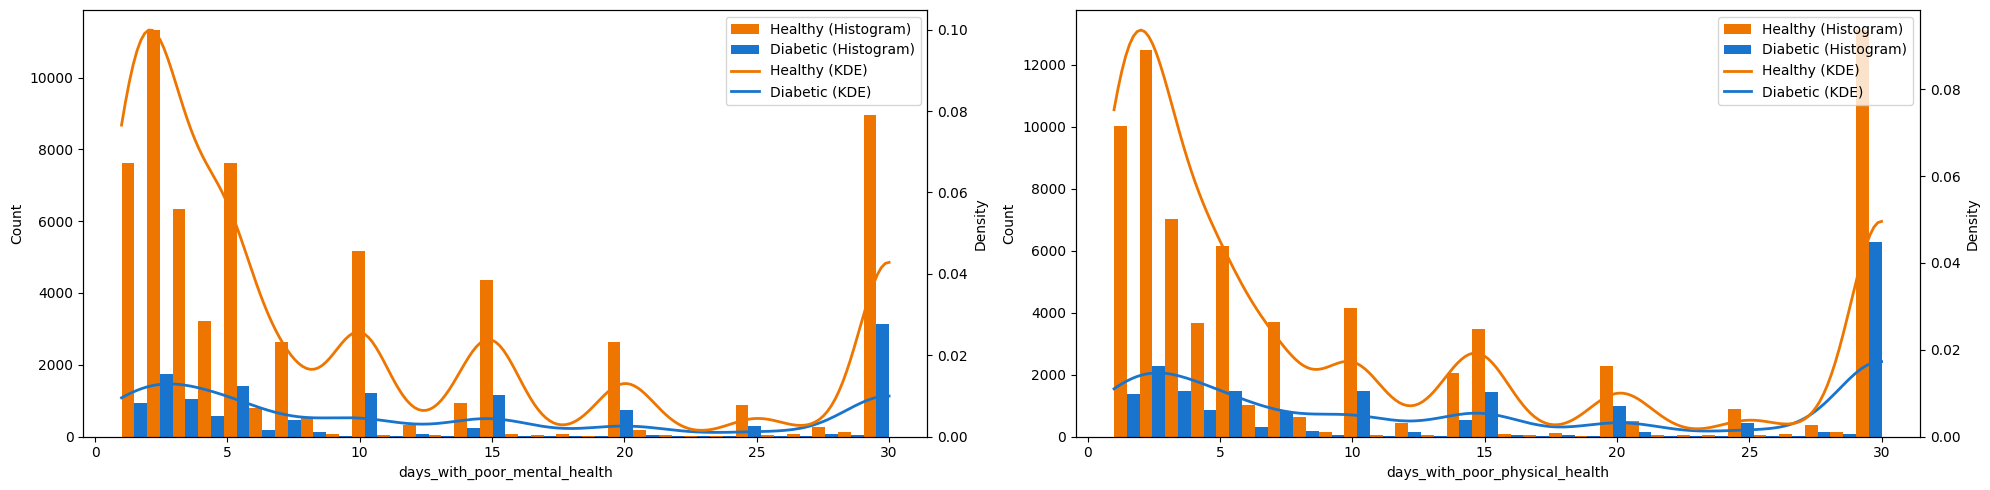

In [ ]:
# Columns to plot (exclude zeros)
non_zero_cols = [
    "days_with_poor_mental_health",
    "days_with_poor_physical_health"
]

hue_order = ["healthy", "diabetic"]
palette = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

hist_alpha = 1.0
kde_alpha = 1.0

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.flatten()

for i, col in enumerate(non_zero_cols):
    data = df_eda[df_eda[col] > 0]

    # Histogram (counts)
    sns.histplot(
        data=data,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        multiple="dodge",
        bins=30,
        palette=palette,
        alpha=hist_alpha,
        edgecolor=None,
        ax=axes[i]
    )

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

    # KDE (density) on secondary axis
    ax2 = axes[i].twinx()

    sns.kdeplot(
        data=data,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        palette=palette,
        linewidth=2,
        alpha=kde_alpha,
        clip=(1, 30),
        ax=ax2,
        legend=False
    )

    ax2.set_ylabel("Density")


    legend_elements = [
        Patch(facecolor=palette["healthy"], alpha=hist_alpha, label="Healthy (Histogram)"),
        Patch(facecolor=palette["diabetic"], alpha=hist_alpha, label="Diabetic (Histogram)"),
        Line2D([0], [0], color=palette["healthy"], lw=2, alpha=kde_alpha, label="Healthy (KDE)"),
        Line2D([0], [0], color=palette["diabetic"], lw=2, alpha=kde_alpha, label="Diabetic (KDE)")
    ]

    axes[i].legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

Extreme values were identified for body mass index (BMI < 15 and BMI > 60). However, the overall shape of the BMI distribution is broadly similar for diabetic and non-diabetic individuals, with no clear separation toward higher BMI values among the diabetic group at the marginal level. This suggests that, in this dataset, BMI alone does not strongly discriminate diabetes status. This pattern may partially reflect the fact that BMI is a derived variable based on self-reported height and weight, which are subject to measurement error and reporting bias in large population surveys.

For self-reported mental and physical health measures, a substantial proportion of respondents reported high numbers of affected days (up to 30 out of 30), with a marked concentration at round values (e.g., 5, 10, 15, 30 days). This heaping pattern is observed in both diabetic and non-diabetic individuals and is likely consistent with response heaping (anchoring), a well-described effect in self-reported count data, rather than data entry errors. While extreme BMI values likely represent rare but plausible observations, the clustering observed in mental and physical health reflects structural characteristics of the measurement process. As both phenomena involve a non-negligible fraction of the sample and do not provide sufficient evidence of data corruption, all observations were retained for downstream analyses.

<font color="#00868B" size = "3"><b>Visualizing data from non-numerical columns</b></font>

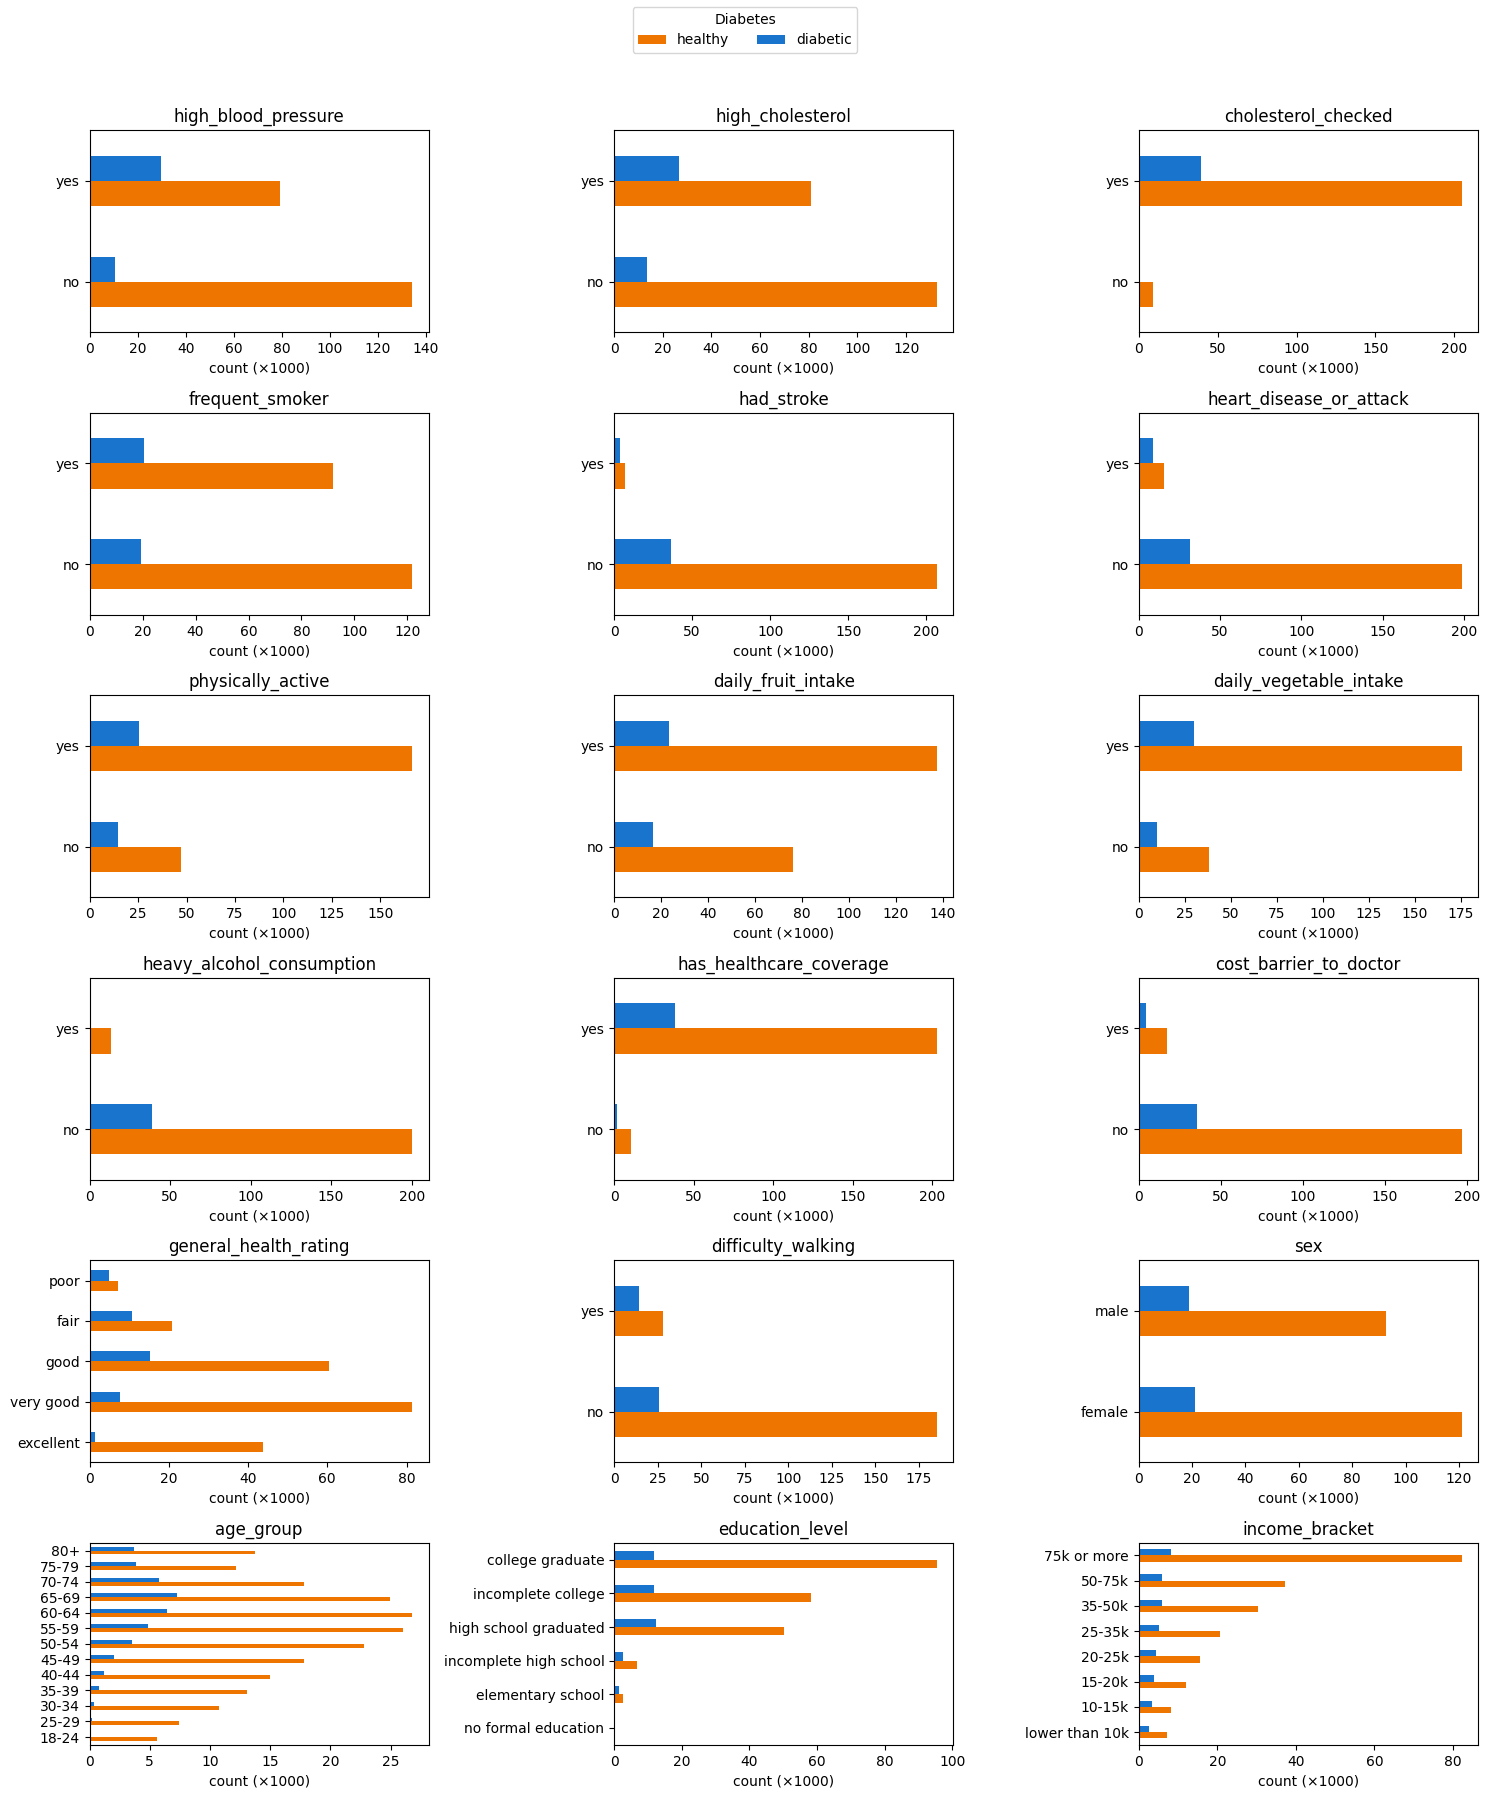

In [ ]:
categorical_columns = [
    col for col in df_eda.columns
    if col != "diabetes_status"
    and df_eda[col].dtype == "category"
]

n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 3)
)
axes = axes.flatten()

scale = 1000

color_map = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

for i, col in enumerate(categorical_columns):
    ct = pd.crosstab(df_eda[col], df_eda["diabetes_status"])
    ct_scaled = ct / scale

    colors = [color_map[c] for c in ct_scaled.columns]

    ct_scaled.plot(
        kind="barh",
        ax=axes[i],
        legend=False,
        color=colors
    )

    axes[i].set_title(col)
    axes[i].set_xlabel(f"count (×{scale})")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Diabetes",
    loc="upper center",
    ncol=2
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Visual inspection of categorical variables reveals consistent and biologically plausible differences between diabetic and non-diabetic individuals. Diabetes shows a clear association with cardiometabolic comorbidities, including a higher prevalence of hypertension and hypercholesterolemia. Compared to healthy individuals, diabetic participants report worse self-perceived health status and a higher frequency of mobility limitations. In addition, diabetes prevalence increases progressively with age. Overall, these patterns are coherent with established epidemiological evidence and support the validity of the dataset for exploratory analysis and downstream predictive modeling.

#Model training and evaluation

Two supervised classification models were selected for this analysis: logistic regression as an interpretable baseline, and CatBoost as a gradient boosting model well suited for datasets with a high proportion of categorical variables.

This approach allows assessing whether increasing model complexity leads to meaningful performance improvements while maintaining a clear comparison framework.

The problem is framed as a risk screening task rather than a diagnostic tool. Consequently, model evaluation focuses on recall for the diabetic class and ROC-AUC, prioritizing the identification of at-risk individuals over minimizing false positives.

<font color="#00868B" size = "3"><b>Model 1: Logistic regression</b></font>

In [ ]:
# Define X and y variables
X_LR = df.drop(columns="diabetes_status")
y_LR = df["diabetes_status"] #"healthy": 0, "diabetes": 1


# Split data in train and test
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    X_LR,
    y_LR,
    test_size=0.2,
    random_state=42,
    stratify=y_LR
)

In [ ]:
# OneHotEncoding of categorical (non-binary) columns and Scaling for numerical columns

cat_non_binary_cols = ["general_health_rating", "age_group", "education_level", "income_bracket"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_non_binary_cols),
        ("num", StandardScaler(), numerical_columns)
    ],
    remainder="passthrough"
)

X_train_LR_encoded = preprocessor.fit_transform(X_train_LR)
X_test_LR_encoded  = preprocessor.transform(X_test_LR)

In [ ]:
feature_names = preprocessor.get_feature_names_out()
print(feature_names)

['cat__general_health_rating_2.0' 'cat__general_health_rating_3.0'
 'cat__general_health_rating_4.0' 'cat__general_health_rating_5.0'
 'cat__age_group_2.0' 'cat__age_group_3.0' 'cat__age_group_4.0'
 'cat__age_group_5.0' 'cat__age_group_6.0' 'cat__age_group_7.0'
 'cat__age_group_8.0' 'cat__age_group_9.0' 'cat__age_group_10.0'
 'cat__age_group_11.0' 'cat__age_group_12.0' 'cat__age_group_13.0'
 'cat__education_level_2.0' 'cat__education_level_3.0'
 'cat__education_level_4.0' 'cat__education_level_5.0'
 'cat__education_level_6.0' 'cat__income_bracket_2.0'
 'cat__income_bracket_3.0' 'cat__income_bracket_4.0'
 'cat__income_bracket_5.0' 'cat__income_bracket_6.0'
 'cat__income_bracket_7.0' 'cat__income_bracket_8.0'
 'num__body_mass_index' 'num__days_with_poor_mental_health'
 'num__days_with_poor_physical_health' 'remainder__high_blood_pressure'
 'remainder__high_cholesterol' 'remainder__cholesterol_checked'
 'remainder__frequent_smoker' 'remainder__had_stroke'
 'remainder__heart_disease_or_att

In [ ]:
#Check correct encoding and scaling for a single data sample

idx = X_train_LR.index[0]

original_row = X_train_LR.loc[idx].to_frame(name="original_value")

X_train_LR_encoded_df = pd.DataFrame(
    X_train_LR_encoded,
    columns=preprocessor.get_feature_names_out(),
    index=X_train_LR.index
)

encoded_row = X_train_LR_encoded_df.loc[idx].to_frame(name="encoded/scaled_value")

print(original_row)
print("----------------------------------------------------------")
print(encoded_row)

                                original_value
high_blood_pressure                        1.0
high_cholesterol                           1.0
cholesterol_checked                        1.0
body_mass_index                           28.0
frequent_smoker                            0.0
had_stroke                                 0.0
heart_disease_or_attack                    1.0
physically_active                          0.0
daily_fruit_intake                         1.0
daily_vegetable_intake                     1.0
heavy_alcohol_consumption                  0.0
has_healthcare_coverage                    1.0
cost_barrier_to_doctor                     1.0
general_health_rating                      4.0
days_with_poor_mental_health               0.0
days_with_poor_physical_health             5.0
difficulty_walking                         1.0
sex                                        1.0
age_group                                 13.0
education_level                            5.0
income_bracke

In [ ]:
# Initialize Logistic regression and grid search CV
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")

param_grid_LR = [
    {"solver": ["lbfgs"], "penalty": ["l2"], "C": [0.01, 0.1, 1, 10]},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['l2', None], 'C': [0.01, 0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10], 'l1_ratio':[0.5]}
]

grid_search_LR = GridSearchCV(logreg, param_grid_LR, cv=4, scoring='roc_auc', n_jobs=-1, verbose=1)

# Model training
grid_search_LR.fit(X_train_LR_encoded, y_train_LR)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', None],
                          'solver': ['saga']},
                         {'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.5],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [ ]:
# Display the best hyperparameters found by the grid search
print("Best hyperparameters:")
print(grid_search_LR.best_params_)

Best hyperparameters:
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


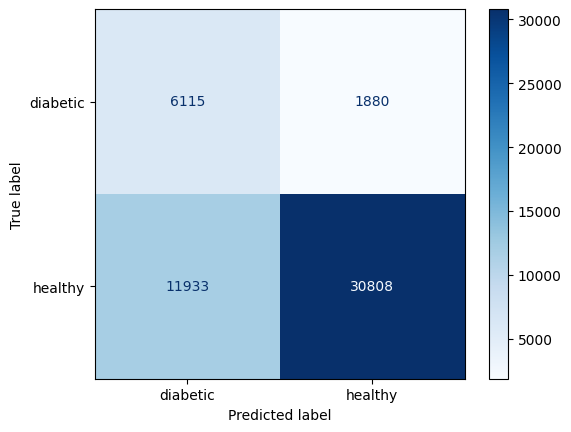

In [ ]:
# Confusion matrix
y_pred_LR = grid_search_LR.predict(X_test_LR_encoded)

cm_LR = confusion_matrix(
    y_test_LR,
    y_pred_LR,
    labels=[1, 0]   # 1 = diabetic, 0 = healthy
)

disp_LR = ConfusionMatrixDisplay(
    confusion_matrix=cm_LR,
    display_labels=["diabetic", "healthy"]
)

disp_LR.plot(cmap="Blues")

In [ ]:
# Display model performance metrics
print("\nClassification report:")
print(classification_report(y_test_LR, y_pred_LR, target_names=["healthy", "diabetic"]))

# Best model from GridSearch
best_model_LR = grid_search_LR.best_estimator_

# Probabilities
y_train_prob_LR = best_model_LR.predict_proba(X_train_LR_encoded)[:, 1]
y_test_prob_LR  = best_model_LR.predict_proba(X_test_LR_encoded)[:, 1]

# ROC-AUC
roc_auc_train_LR = roc_auc_score(y_train_LR, y_train_prob_LR)
roc_auc_test_LR  = roc_auc_score(y_test_LR, y_test_prob_LR)

print(f"Logistic Regression ROC-AUC (Train): {roc_auc_train_LR:.4f}")
print(f"Logistic Regression ROC-AUC (Test):  {roc_auc_test_LR:.4f}")


Classification report:
              precision    recall  f1-score   support

     healthy       0.94      0.72      0.82     42741
    diabetic       0.34      0.76      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.73      0.76     50736

Logistic Regression ROC-AUC (Train): 0.8201
Logistic Regression ROC-AUC (Test):  0.8195


In [ ]:
# Feature importance
feature_names_LR = preprocessor.get_feature_names_out()
coefs_LR = best_model_LR.coef_[0]

feat_imp_LR = pd.DataFrame({
    'feature': feature_names_LR,
    'coefficient': coefs_LR,
    'abs_coefficient': np.abs(coefs_LR)
})

feat_imp = feat_imp_LR.sort_values(by='abs_coefficient', ascending=False)
print(feat_imp_LR)

                                 feature  coefficient  abs_coefficient
0         cat__general_health_rating_2.0     0.692541         0.692541
1         cat__general_health_rating_3.0     1.355394         1.355394
2         cat__general_health_rating_4.0     1.800033         1.800033
3         cat__general_health_rating_5.0     1.886759         1.886759
4                     cat__age_group_2.0     0.048762         0.048762
5                     cat__age_group_3.0     0.291043         0.291043
6                     cat__age_group_4.0     0.706491         0.706491
7                     cat__age_group_5.0     0.877418         0.877418
8                     cat__age_group_6.0     1.106034         1.106034
9                     cat__age_group_7.0     1.312740         1.312740
10                    cat__age_group_8.0     1.424560         1.424560
11                    cat__age_group_9.0     1.638118         1.638118
12                   cat__age_group_10.0     1.825535         1.825535
13    

<font color="#8B008B" size = "3"><b>Logistic Regression Results and Interpretation</b></font>

Logistic regression was used as an interpretable baseline model. After hyperparameter tuning with cross-validation and class weighting to address class imbalance, the model achieved a ROC-AUC of approximately 0.82. The nearly identical ROC-AUC values observed on the training (0.8201) and test (0.8195) sets suggest good generalization performance and no strong evidence of overfitting.

The model favors recall for the diabetic class (0.76), reducing false negatives at the cost of a higher number of false positives. This behavior is appropriate for a screening-oriented use case, where missing true diabetic cases is more costly than incorrectly flagging healthy individuals for further testing.

To improve interpretability, model coefficients were analyzed and ranked by absolute magnitude. The most influential features were primarily related to older age groups, self-reported general health status, and known clinical risk factors, supporting the use of logistic regression as a transparent and well-aligned baseline model.

<font color="#00868B" size = "3"><b>Model 2: CatBoost</b></font>

In [ ]:
df.dtypes

,0
diabetes_status,category
high_blood_pressure,category
high_cholesterol,category
cholesterol_checked,category
body_mass_index,int64
frequent_smoker,category
had_stroke,category
heart_disease_or_attack,category
physically_active,category
daily_fruit_intake,category


In [ ]:
# Define X and y variables adapted this time to CatBoost requirements
X_CB = df.drop(columns="diabetes_status")

categorical_columns = X_CB.select_dtypes(include=["category"]).columns.tolist()
for col in categorical_columns:
    X_CB[col] = X_CB[col].astype(str)

y_CB = df["diabetes_status"] #"healthy": 0, "diabetes": 1

# Split data in train and test
X_train_CB, X_test_CB, y_train_CB, y_test_CB = train_test_split(
    X_CB,
    y_CB,
    test_size=0.2,
    random_state=42,
    stratify=y_CB
)

# Obtain index from categorical features
cat_features_idx = [
    X_train_CB.columns.get_loc(col)
    for col in categorical_columns
]

# Grid
param_grid_CB = {
    "depth": [6, 8],
    "learning_rate": [0.03, 0.1],
    "iterations": [500, 1000],
    "l2_leaf_reg": [3, 7],
}

# Initialize CatBoost classifier and grid search CV
CB = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, (y_train_CB == 0).sum() / (y_train_CB == 1).sum()],
    random_seed=42,
    verbose=0
)


grid_search_CB = GridSearchCV(
    estimator=CB,
    param_grid=param_grid_CB,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Model training
grid_search_CB.fit(
    X_train_CB,
    y_train_CB,
    cat_features=cat_features_idx
)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x7bac20283500>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [500, 1000],
                         'l2_leaf_reg': [3, 7], 'learning_rate': [0.03, 0.1]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Best hyperparameters
best_CB = grid_search_CB.best_estimator_
print("Best hyperparameters:", grid_search_CB.best_params_)

y_pred_CB = best_CB.predict(X_test_CB)

Best hyperparameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 7, 'learning_rate': 0.03}


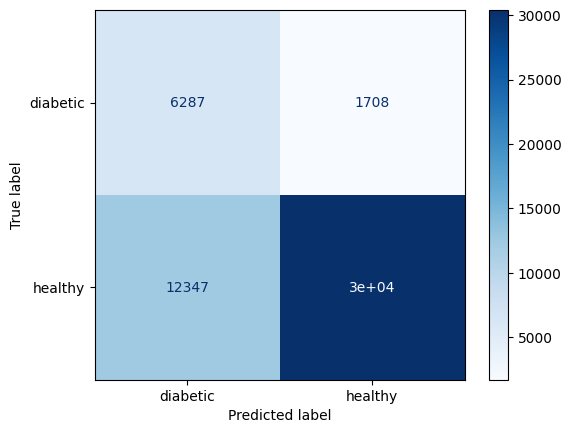

In [ ]:
# Confusion Matrix
cm_CB = confusion_matrix(
    y_test_CB,
    y_pred_CB,
    labels=[1, 0]
)

disp_CB = ConfusionMatrixDisplay(
    confusion_matrix=cm_CB,
    display_labels=["diabetic", "healthy"]
)

disp_CB.plot(cmap="Blues")

In [ ]:
# Probabilities
y_train_prob_CB = best_CB.predict_proba(X_train_CB)[:, 1]
y_test_prob_CB  = best_CB.predict_proba(X_test_CB)[:, 1]

# Metrics
print("\nClassification report:")
print(classification_report(y_test_CB, y_pred_CB, target_names=["healthy", "diabetic"]))

# ROC-AUC
roc_auc_train_CB = roc_auc_score(y_train_CB, y_train_prob_CB)
roc_auc_test_CB  = roc_auc_score(y_test_CB, y_test_prob_CB)

print(f"CatBoost ROC-AUC (Train): {roc_auc_train_CB:.4f}")
print(f"CatBoost ROC-AUC (Test):  {roc_auc_test_CB:.4f}")


Classification report:
              precision    recall  f1-score   support

     healthy       0.95      0.71      0.81     42741
    diabetic       0.34      0.79      0.47      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.75      0.64     50736
weighted avg       0.85      0.72      0.76     50736

CatBoost ROC-AUC (Train): 0.8323
CatBoost ROC-AUC (Test):  0.8257


In [ ]:
# Feature importance
feat_imp_CB_df = pd.DataFrame({
    'feature': best_CB.feature_names_,
    'importance': best_CB.get_feature_importance()
}).sort_values(by='importance', ascending=False)

print(feat_imp_CB_df)

                           feature  importance
13           general_health_rating   24.689283
18                       age_group   19.830344
3                  body_mass_index   16.150054
0              high_blood_pressure    9.447406
1                 high_cholesterol    6.383351
2              cholesterol_checked    5.515923
20                  income_bracket    4.748106
17                             sex    2.521116
10       heavy_alcohol_consumption    1.987422
19                 education_level    1.864432
14    days_with_poor_mental_health    1.395573
15  days_with_poor_physical_health    1.120197
6          heart_disease_or_attack    1.099122
16              difficulty_walking    0.788192
4                  frequent_smoker    0.621101
8               daily_fruit_intake    0.420933
7                physically_active    0.387998
11         has_healthcare_coverage    0.357843
9           daily_vegetable_intake    0.301131
5                       had_stroke    0.232450
12          c

<font color="#8B008B" size = "3"><b>CatBoost — Results and Interpretation</b></font>

CatBoost achieved a ROC-AUC of approximately 0.83, slightly outperforming logistic regression in overall discriminative performance. As with the logistic regression model, similar ROC-AUC values on the training (0.8323) and test (0.8257) sets suggest good generalization and no strong evidence of overfitting. At the default classification threshold, CatBoost exhibited higher recall for the diabetic class (≈ 0.79), reducing false negatives relative to the logistic regression baseline.

This improvement comes at the cost of a comparable number of false positives, indicating that CatBoost shifts the decision boundary toward greater sensitivity rather than improving precision. Feature importance analysis highlights general health rating, age group, body mass index, and cardiovascular risk factors as the most influential variables, consistent with both domain knowledge and the patterns observed in the linear model.

Overall, CatBoost captures limited non-linear structure beyond what is already learned by logistic regression, resulting in a modest but measurable reduction in missed diabetic cases.

<font color="#00868B" size = "3"><b>Model Comparison and Use-Case Recommendation</b></font>

Both models show similar overall performance, suggesting that the dataset’s predictive structure is largely linear. Logistic regression provides strong baseline performance with high interpretability, robustness, and ease of deployment, making it well suited for scenarios where transparency and simplicity are prioritized.

CatBoost offers a small but consistent improvement in recall for the diabetic class, reducing false negatives in comparison to logistic regression. This behavior is advantageous in screening-oriented use cases, where the primary objective is to identify as many at-risk individuals as possible, even at the expense of additional false positives that can be addressed through follow-up testing.

Considering the characteristics of the dataset and the modest performance gains observed, logistic regression emerges as the recommended model for this application. Its transparency, stability, and ease of interpretation make it better aligned with real-world deployment in health screening contexts based on self-reported survey data.

In a screening setting, model behavior could be further adapted by adjusting the classification threshold to prioritize sensitivity for the diabetic class, depending on operational constraints and downstream capacity. Such calibration would allow balancing recall and false positives without requiring model retraining.

Taken together, these results highlight the trade-off between interpretability and sensitivity in medical risk screening models, while supporting logistic regression as the preferred default approach for this dataset.

#Data prediction

<font color="#00868B" size = "3"><b>Simulated deployment on unseen data</b></font>

The trained logistic regression model was applied to the test dataset, treated as unlabeled/unseen data.
Predictions are provided together with estimated probabilities and confidence levels.
High-confidence predictions (probability ≥ 0.8) can be used for automated decision-making, while medium and low-confidence cases may require manual review.

In [ ]:
predictions_LR_df = pd.DataFrame({
    "prediction": y_pred_LR,
    "probability_diabetic": y_test_prob_LR
}, index=X_test_LR.index)

In [ ]:
def confidence_flag(p):
    if p >= 0.8:
        return "high"
    elif p >= 0.6:
        return "medium"
    else:
        return "low"

predictions_LR_df["confidence_flag"] = predictions_LR_df["probability_diabetic"].apply(confidence_flag)

In [ ]:
predictions_df = predictions_LR_df.sort_values(by="probability_diabetic", ascending=False)
predictions_df["prediction"] = predictions_df["prediction"].replace({0: "healthy", 1: "diabetes"})

In [ ]:
predictions_df.sample(20)

,prediction,probability_diabetic,confidence_flag
49632,healthy,0.331960,low
229700,healthy,0.028010,low
234636,healthy,0.391893,low
209364,healthy,0.253978,low
129089,diabetes,0.891887,high
118257,healthy,0.426598,low
208019,healthy,0.421538,low
19122,healthy,0.450788,low
175333,healthy,0.281508,low
139170,healthy,0.119827,low


**Note:** In a real deployment, the selected model would typically be retrained on all available labeled data before generating predictions on new, unlabeled records.